# Emotion Detection

## Importing Libraries

In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


## Exploring Dataset

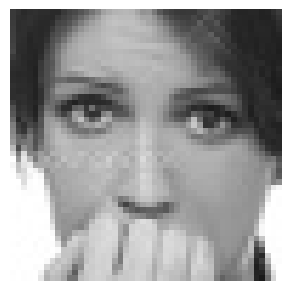

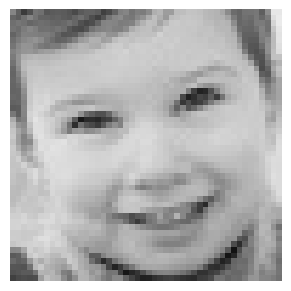

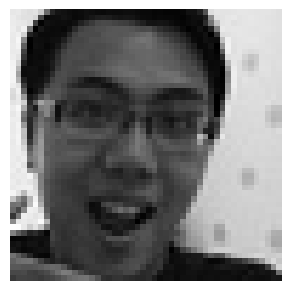

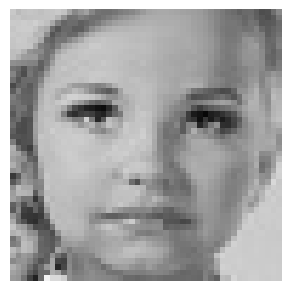

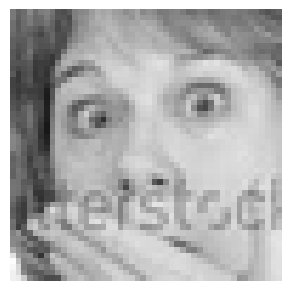

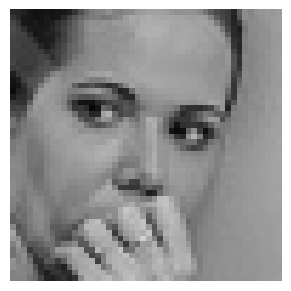

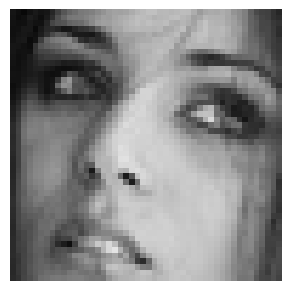

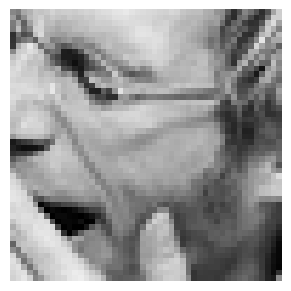

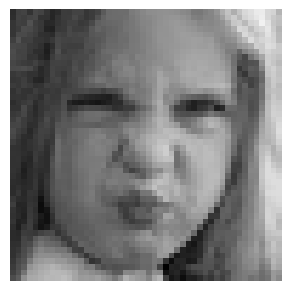

In [3]:
images = glob("../input/fer2013/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## Preparing Data for Training

In [4]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("../input/fer2013/train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("../input/fer2013/test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Defining Model

In [5]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,64,(3,3))
    conv_2 = Convolution(conv_1,128,(5,5))
    conv_3 = Convolution(conv_2,512,(3,3))
    conv_4 = Convolution(conv_3,128,(3,3))

    flatten = Flatten()(conv_4)

    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1,512)

    output = Dense(7,activation = "softmax")(dense_2)
    model = Model(inputs = [inputs], outputs = [output])
    
    opt = Adam(lr=0.0005)

    model.compile(loss = ['categorical_crossentropy'], optimizer = opt, metrics = ['accuracy'])

    return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

### Initializing the Model

In [9]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor =0.1,patience = 2,min_lr=0.00001)
callbacks = [checkpoint,reduce_lr]

# Training the Model

In [10]:
import scipy

In [11]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.7782 - accuracy: 0.3125
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 520s 1s/step - loss: 1.7782 - accuracy: 0.3125 - val_loss: 1.7934 - val_accuracy: 0.3094 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4405 - accuracy: 0.4424
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 496s 1s/step - loss: 1.4405 - accuracy: 0.4424 - val_loss: 1.3567 - val_accuracy: 0.4773 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.3054 - accuracy: 0.4972
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 493s 1s/step - loss: 1.3054 - accuracy: 0.4972 - val_loss: 1.2387 - val_accuracy: 0.5209 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2453 - accuracy: 0.5248
Epoch 4: saving model to model_weights.h5
448/448 [====

### Model Evaluation

In [12]:
model.evaluate(validation_generator)

113/113 [==============================] - 29s 254ms/step - loss: 0.9842 - accuracy: 0.6332


[0.9842059016227722, 0.6331847310066223]

### Plotting Loss

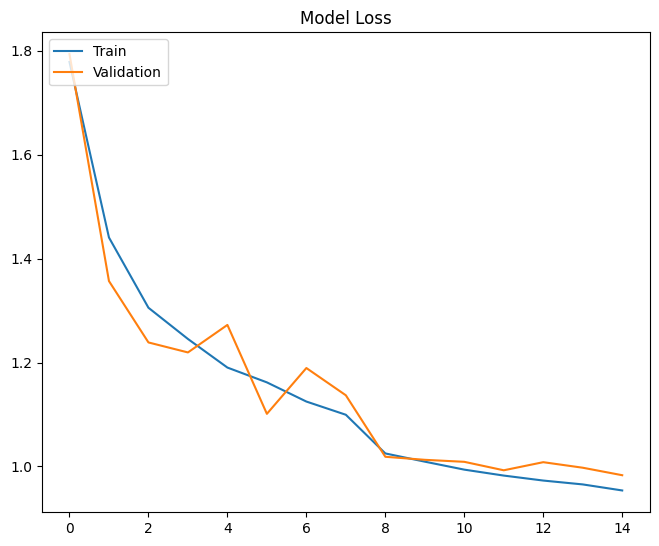

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

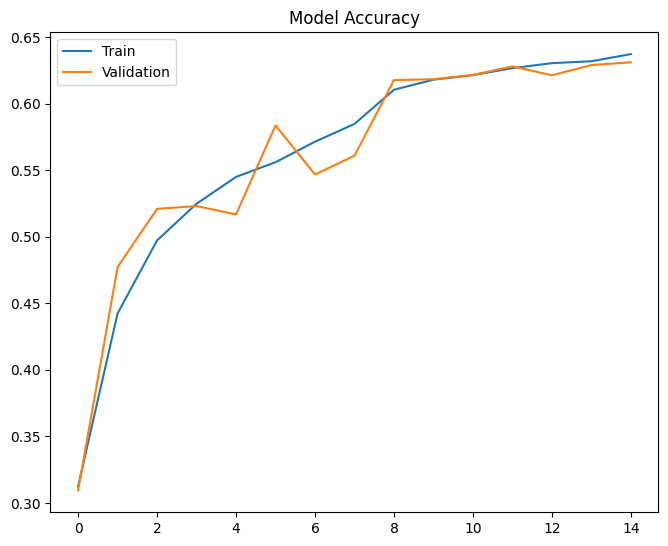

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

### Saving Model

In [16]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)